In [13]:
%matplotlib inline
import psycopg2
import datetime
import pytz
import numpy as np
from pyiem.util import get_dbconn
POSTGIS = get_dbconn('postgis')
cursor = POSTGIS.cursor()

data = {}

cursor.execute("""
  SELECT extract(year from valid) as yr, 
  upper(source) as up, 
  count(*) from lsrs WHERE valid > '2006-01-01'
  and valid < '2018-01-01' and typetext in ('HAIL', 'TORNADO')
  GROUP by yr, up ORDER by yr ASC
  """)
yeartotals = [0]*12
for row in cursor:
    if not data.has_key(row[0]):
        data[row[0]] = {}
    yeartotals[int(row[0])-2006] += row[2]
    data[row[0]][row[1]] = row[2] 
    
POSTGIS.close()


In [14]:
top10 = ['TRAINED SPOTTER',                  
 'PUBLIC',                    
 'MESONET',   
 'COCORAHS',
 'CO-OP OBSERVER',                   
 'EMERGENCY MNGR',                   
 'LAW ENFORCEMENT',                  
 'DEPT OF HIGHWAYS',
 'ASOS',
 'BROADCAST MEDIA',
 '911 CALL CENTER',
 'AMATEUR RADIO',                   
 'NWS EMPLOYEE',
 'SOCIAL MEDIA']
labels = []
y = []

for year in range(2006,2018):
    row = []
    sums = 0
    for t in top10:
        p = data[year].get(t, 0) / float(yeartotals[year-2006]) * 100.
        if year == 2017:
            labels.append("%s %.1f%%" % (t, p))
        row.append( p )
        sums += data[year].get(t, 0)
    p = (float(yeartotals[year-2006]) - sums) / float(yeartotals[year-2006]) * 100.
    row.append( p)
    if year == 2017:
        labels.append("(OTHER) %.1f%%" % (p,))
    y.append(row)


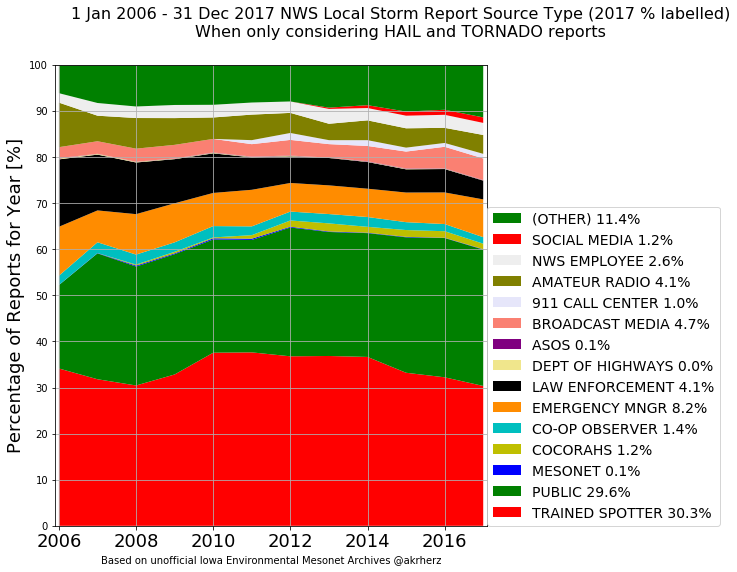

In [15]:
y = np.array(y)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rc('axes', color_cycle=['r', 'g', 'b', 'y', 'c', 'darkorange', 'k', 'khaki', 
                            'purple', 'salmon', 'lavender',
                            'olive', '#EEEEEE'])
fig = plt.figure(figsize=(12,8))
ax = plt.axes([0.1,0.1,0.5,0.8])
stack_coll = ax.stackplot(range(2006,2018), y[:,0], y[:,1], y[:,2], y[:,3], y[:,4], y[:,5], y[:,6]
             , y[:,7], y[:,8], y[:,9], y[:,10], y[:,11], y[:,12], y[:,13], y[:,14])
# make proxy artists
proxy_rects = [Rectangle((0, 0), 1, 1, fc=pc.get_facecolor()[0]) for pc in stack_coll[::-1]]
# make the legend
ax.legend(proxy_rects, labels[::-1], ncol=1, fontsize=14, loc=(1,0.0))
ax.set_xticks(range(2006,2018, 2))
ax.set_xlim(2005.9, 2017.1)
ax.set_xticklabels([str(s) for s in range(2006,2018, 2)], fontsize=18)
ax.set_ylim(0,100)
ax.set_yticks(range(0,101,10))
fig.text(0.5, 0.95, ("1 Jan 2006 - 31 Dec 2017 NWS Local Storm Report Source Type "
                     "(2017 % labelled)\nWhen only considering HAIL and TORNADO "
                     "reports"), ha='center', size=16)
ax.set_xlabel("Based on unofficial Iowa Environmental Mesonet Archives @akrherz")
ax.set_ylabel("Percentage of Reports for Year [%]", fontsize=18)
ax.grid(True)
fig.savefig('test.png', dpi=100)
